# Analysis

In [4]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np

import pickle
import os

In [5]:
# input data folders
PERFORMANCEDIR = "/storage_1/abetti/projects/PWM_SVM/performance"
# test negative data types
BGTEST = ["shuffle", "dnase-1", "dnase"]
BGTRAIN = ["dnase", "shuffle"]

## Kernel Comparison

In [6]:
def compute_mean(infolder, kernel, metric):
    fname = os.path.join(infolder, f"summary_table_kernel_{kernel}_svm.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2)

def compute_std(infolder, kernel, metric):
    fname = os.path.join(infolder, f"summary_table_kernel_{kernel}_svm.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.std(table[metric]).round(2)

def generate_color_variations(base_colors, num_shades=3):
    """Given base colors, it creates a list of base_colors*num_shades colors"""
    extended_colors = []
    for color in base_colors:
        rgb = mcolors.hex2color(color)
        shades = [mcolors.to_hex([(c * (1 - 0.2 * i)) for c in rgb]) for i in range(num_shades)]
        extended_colors.extend(shades)  # Lista piatta con 18 colori distinti
    return extended_colors

def plot(data, std, labels, group_labels, metric, bgtitle):
    num_groups = len(group_labels)  # 6 kernels
    num_bars_per_group = len(labels) // num_groups  # 3 testing scenario
    width = 0.3  # Larghezza delle barre
    
    base_colors = ["#a86464", "#e27c7c", "#466964", "#333333", "#599e94", "#6d4b4b"]
    colors = generate_color_variations(base_colors, num_shades=3)  # 18 colors

    f, ax = plt.subplots(figsize=(20, 6), dpi=300)
    x = np.arange(num_groups)  # Bar positions

    legend_handles = []  # Legend list
    legend_labels = []   
    
    for i in range(num_bars_per_group):
        values = [data[kernel][i] for kernel in group_labels]
        std_values = [std[kernel][i] for kernel in group_labels]
        # Bar color
        color_index = [j * num_bars_per_group + i for j in range(num_groups)]
        bars = ax.bar(x + i * width, values, width, yerr=std_values, capsize=5,
                      color=[colors[idx] for idx in color_index], error_kw={'elinewidth': 1.5})
        for bar, label in zip(bars, labels[i::num_bars_per_group]): 
            if label not in legend_labels:  
                legend_handles.append(bar)  
                legend_labels.append(label)  
        # Max value for each scenario
        max_value = max(values)
        max_indices = [idx for idx, val in enumerate(values) if val == max_value]
        for bar, std_val, idx in zip(bars, std_values, range(len(values))):
            height = bar.get_height()
            text_color = 'red' if idx in max_indices else 'black'
            ax.text(bar.get_x() + bar.get_width() / 2, height + std_val, 
                    f'{height:.2f}', ha='center', va='bottom', fontsize=12, 
                    fontweight='bold' if idx in max_indices else 'normal', color=text_color)
    ax.set_xlabel("Kernel Types", size=20)
    ax.set_ylabel(metric, size=20)
    ax.set_title(f"{metric} - Training on {bgtitle}", size=30)
    ax.set_xticks(x + (num_bars_per_group - 1) * width / 2)
    ax.set_xticklabels(group_labels, size=12)
    #ax.legend(legend_handles, legend_labels, loc='upper center', fontsize=12, frameon=True, ncol=3)
    plt.show()



def barplot(infolder, metric, bg):
    kernels = ["wgkmrbf","wgkm","gkmrbf","gkm","gappedkmer","estlmer"]
    data = {k: [] for k in kernels}
    std = {k: [] for k in kernels}
    for kernel in kernels:
        for i, bt in enumerate(BGTEST):
            tablesdir = os.path.join(infolder, f"{bg}-{bt}")
            data[kernel].append(compute_mean(tablesdir, kernel, metric))
            std[kernel].append(compute_std(tablesdir, kernel, metric))
    labels = [f"{kernel} - test background: {testbg}" for kernel in kernels for testbg in BGTEST]
    bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"
    plot(data, std, labels, kernels, metric, bgtitle)


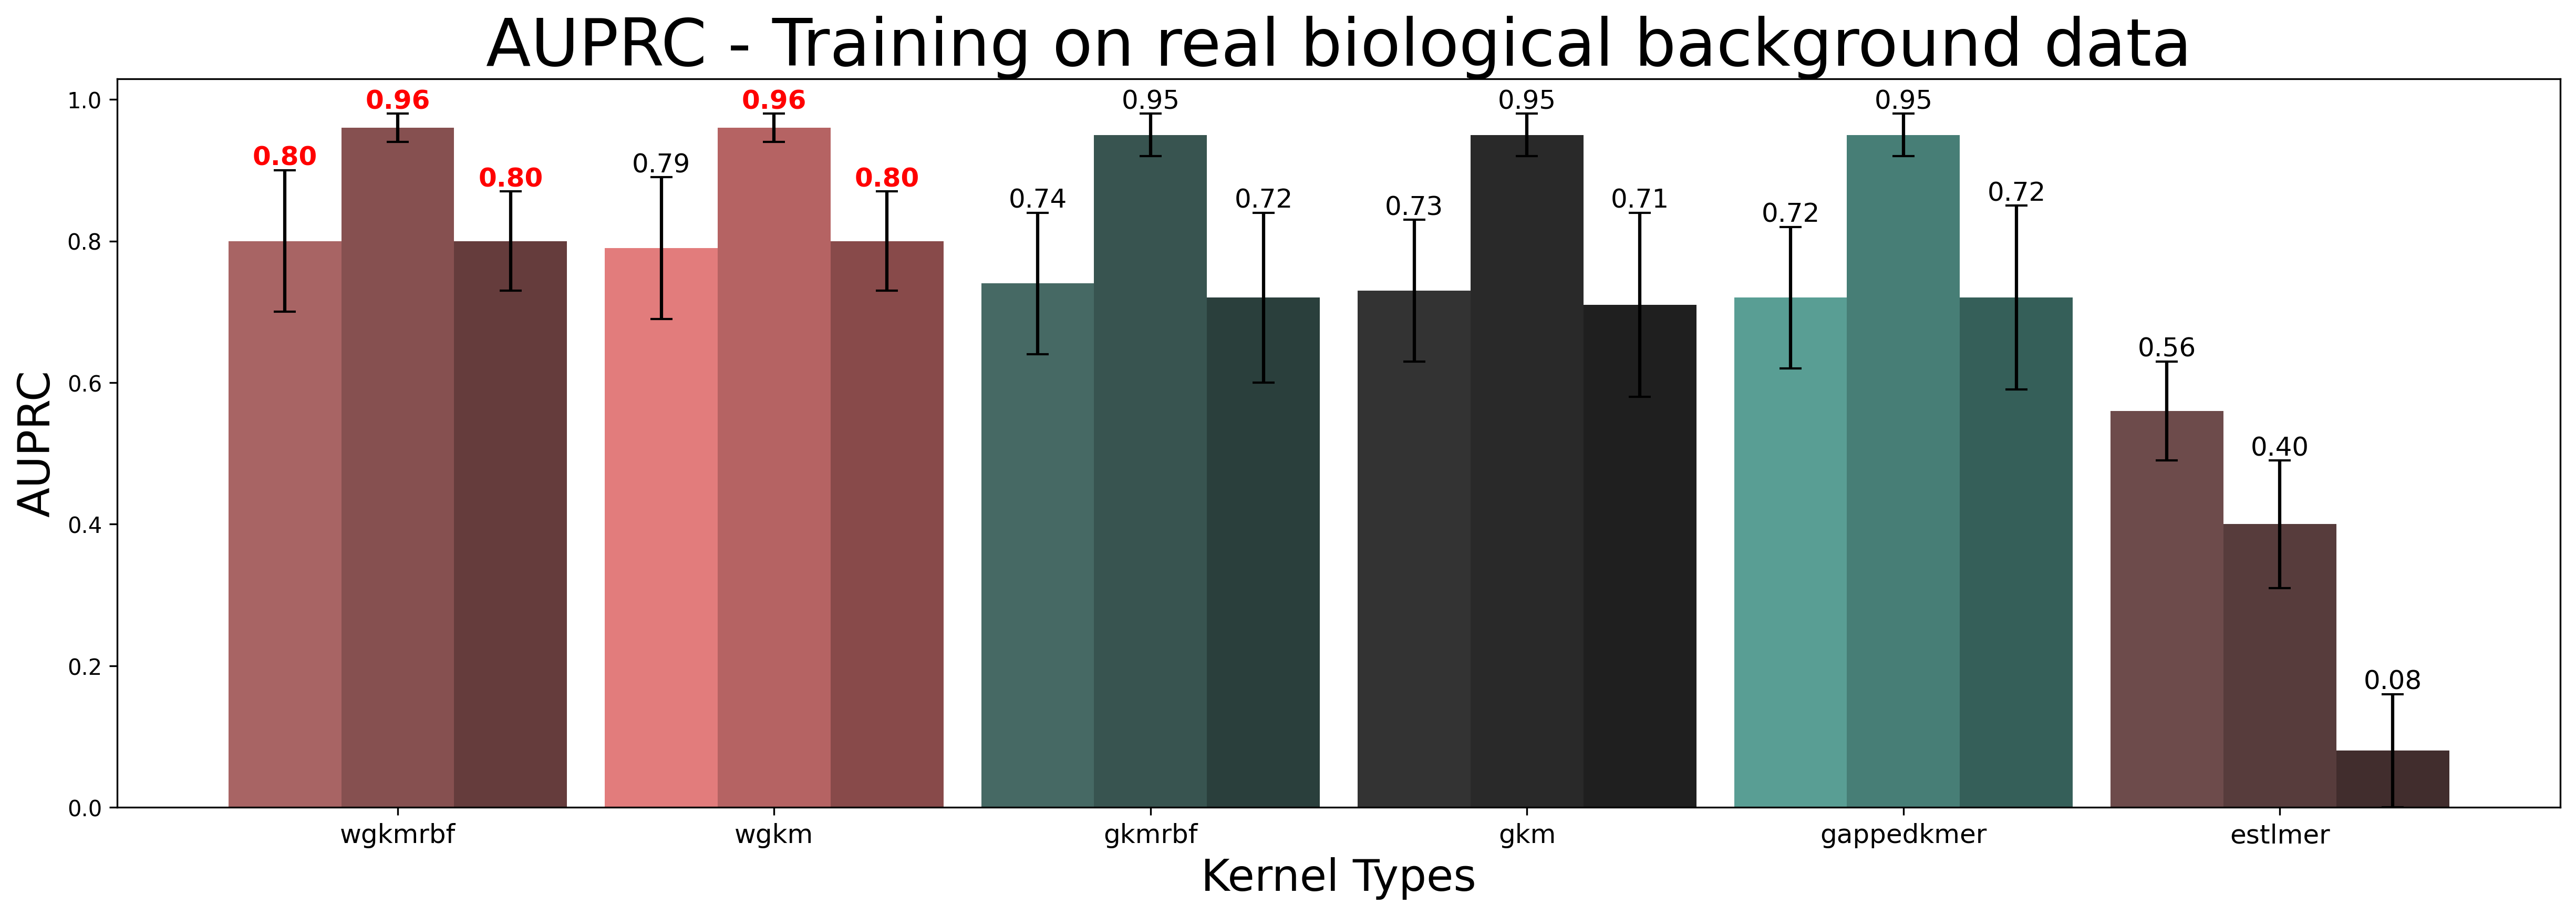

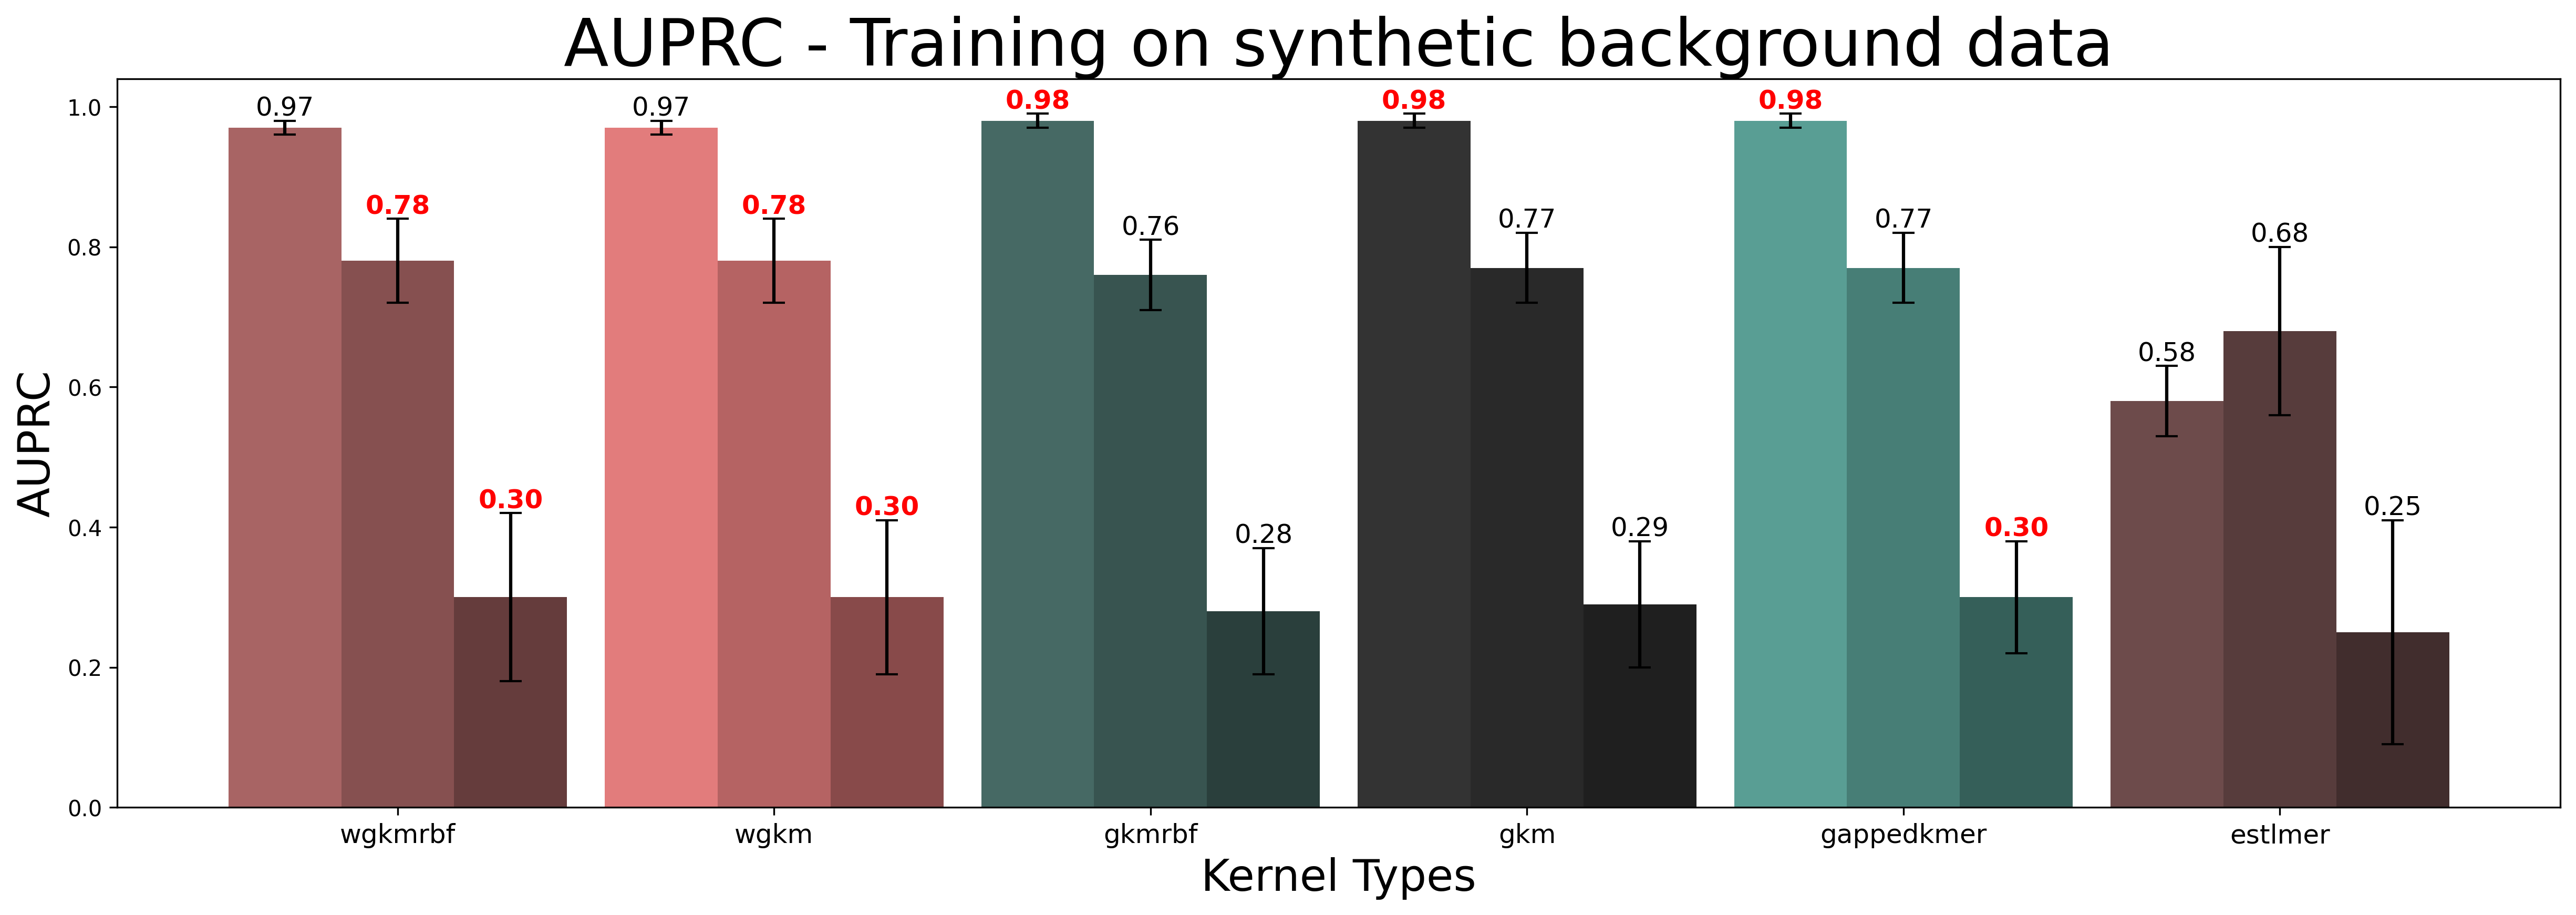

In [7]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in BGTRAIN:
    barplot(performance_dir, "AUPRC", bg)
    

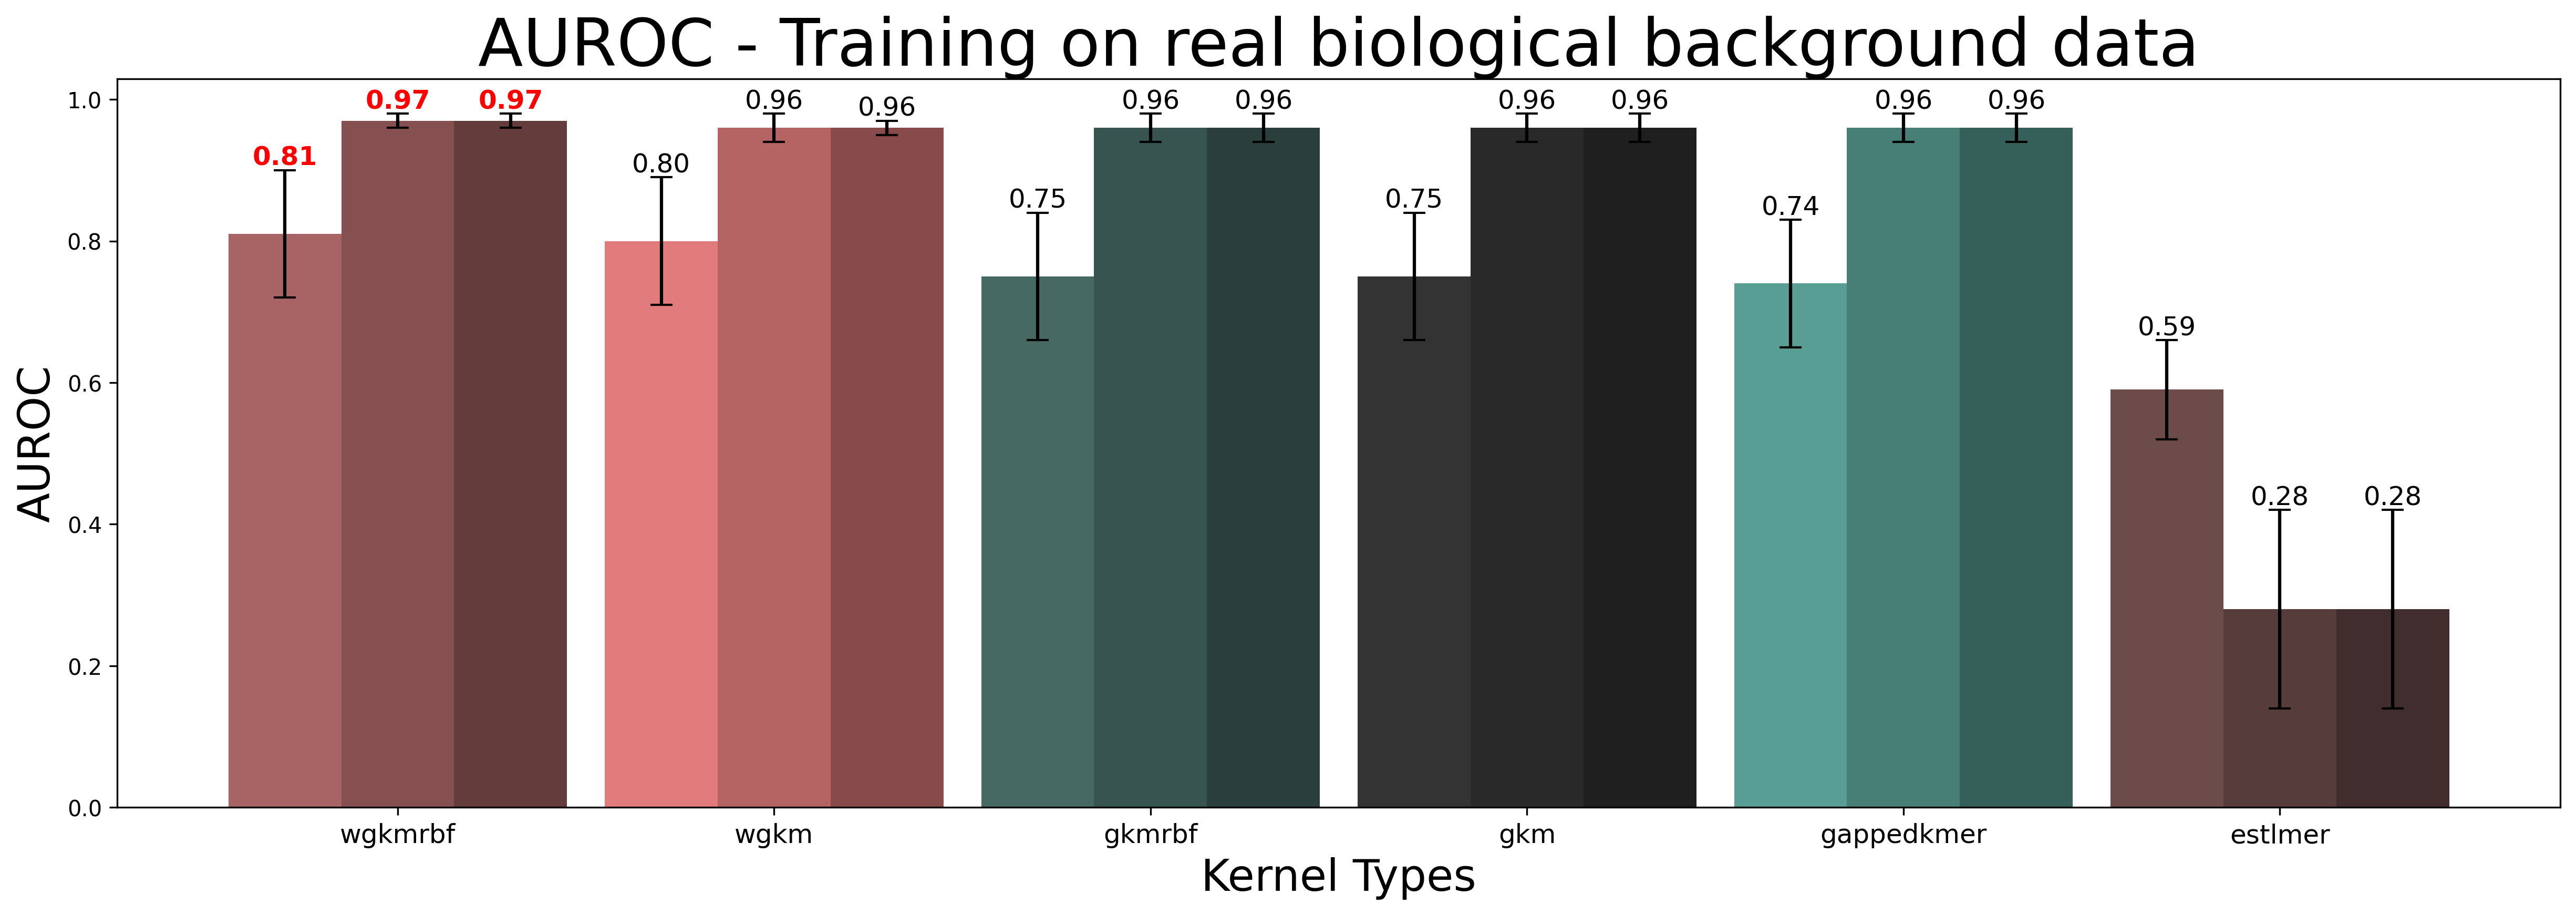

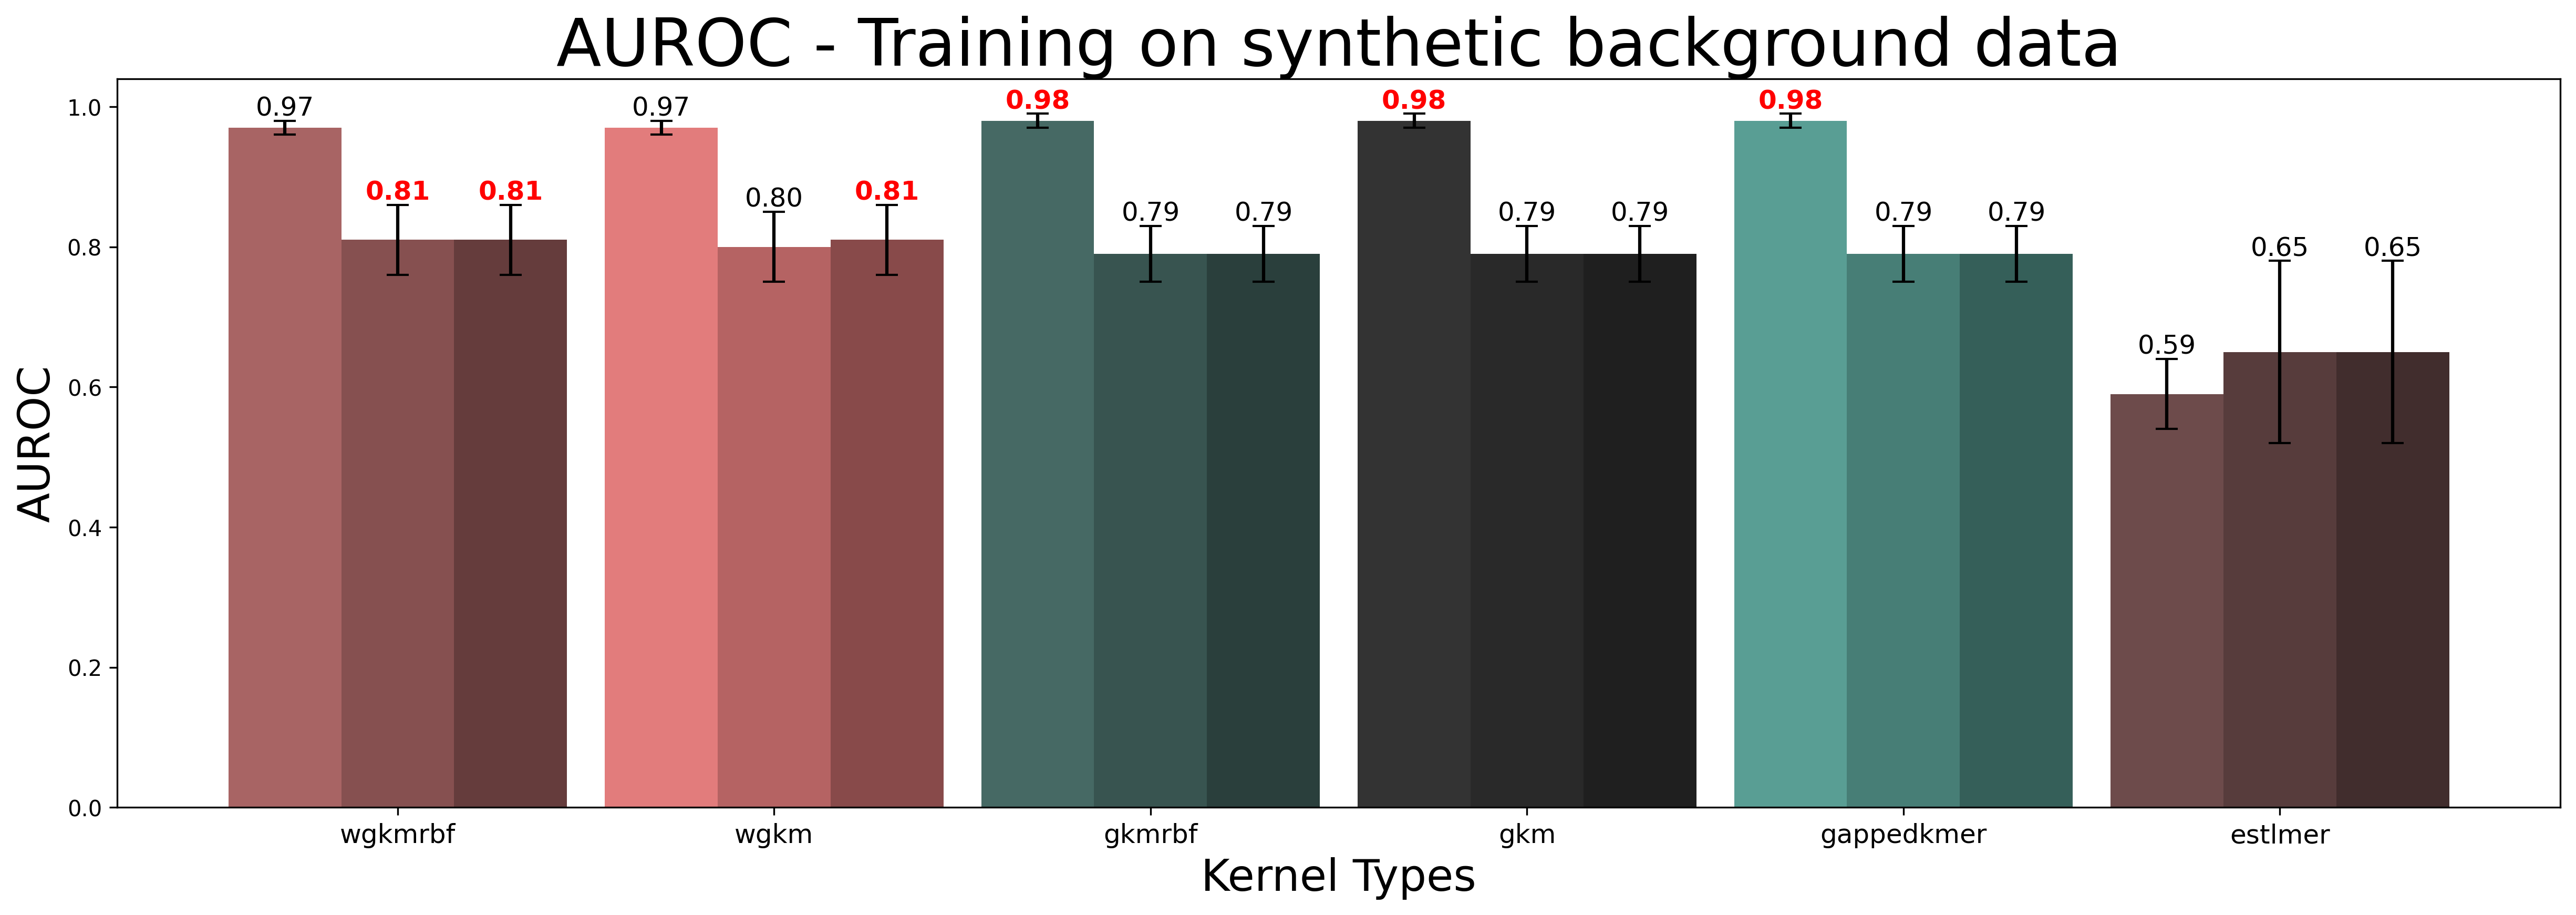

In [8]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in BGTRAIN:
    barplot(performance_dir, "AUROC", bg)
    

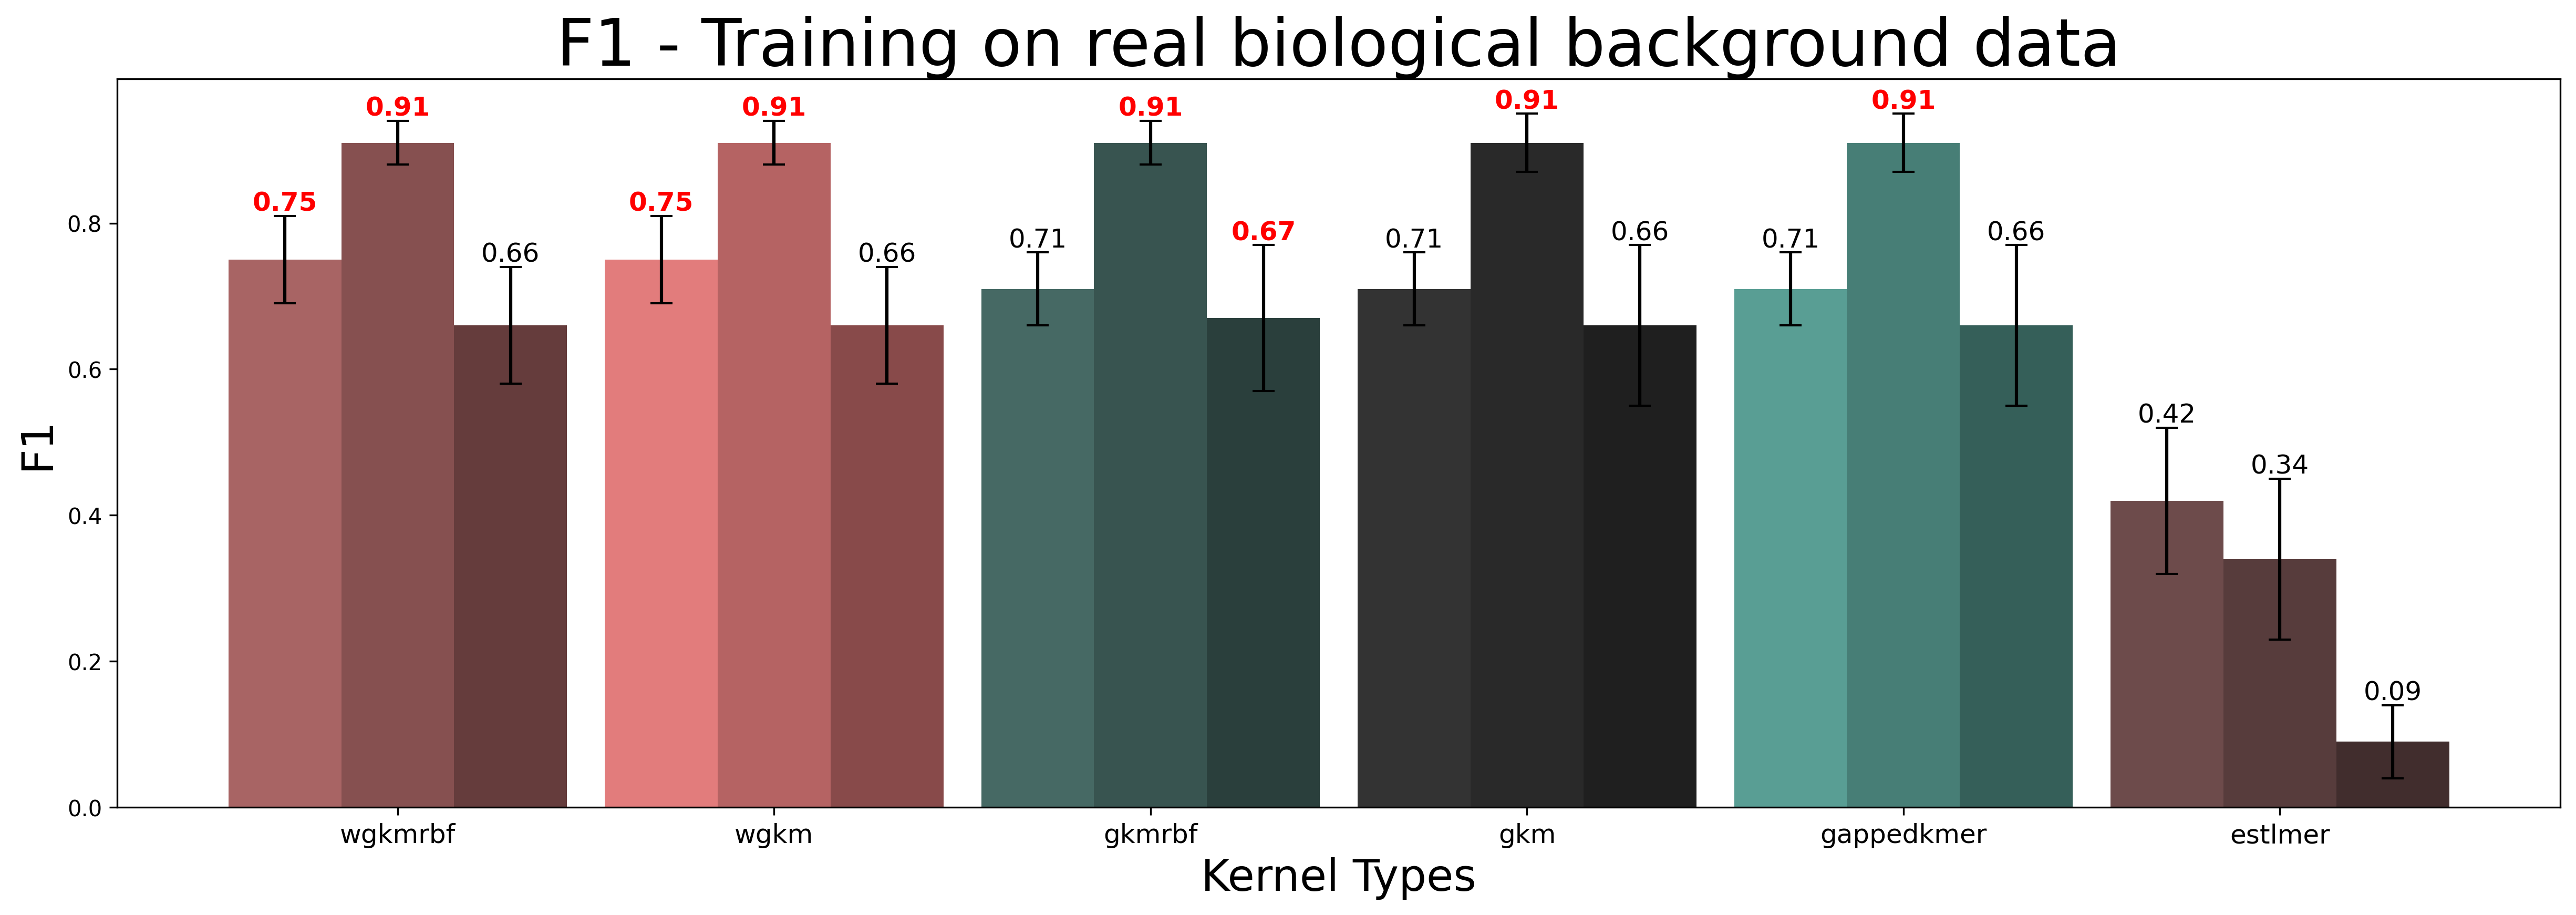

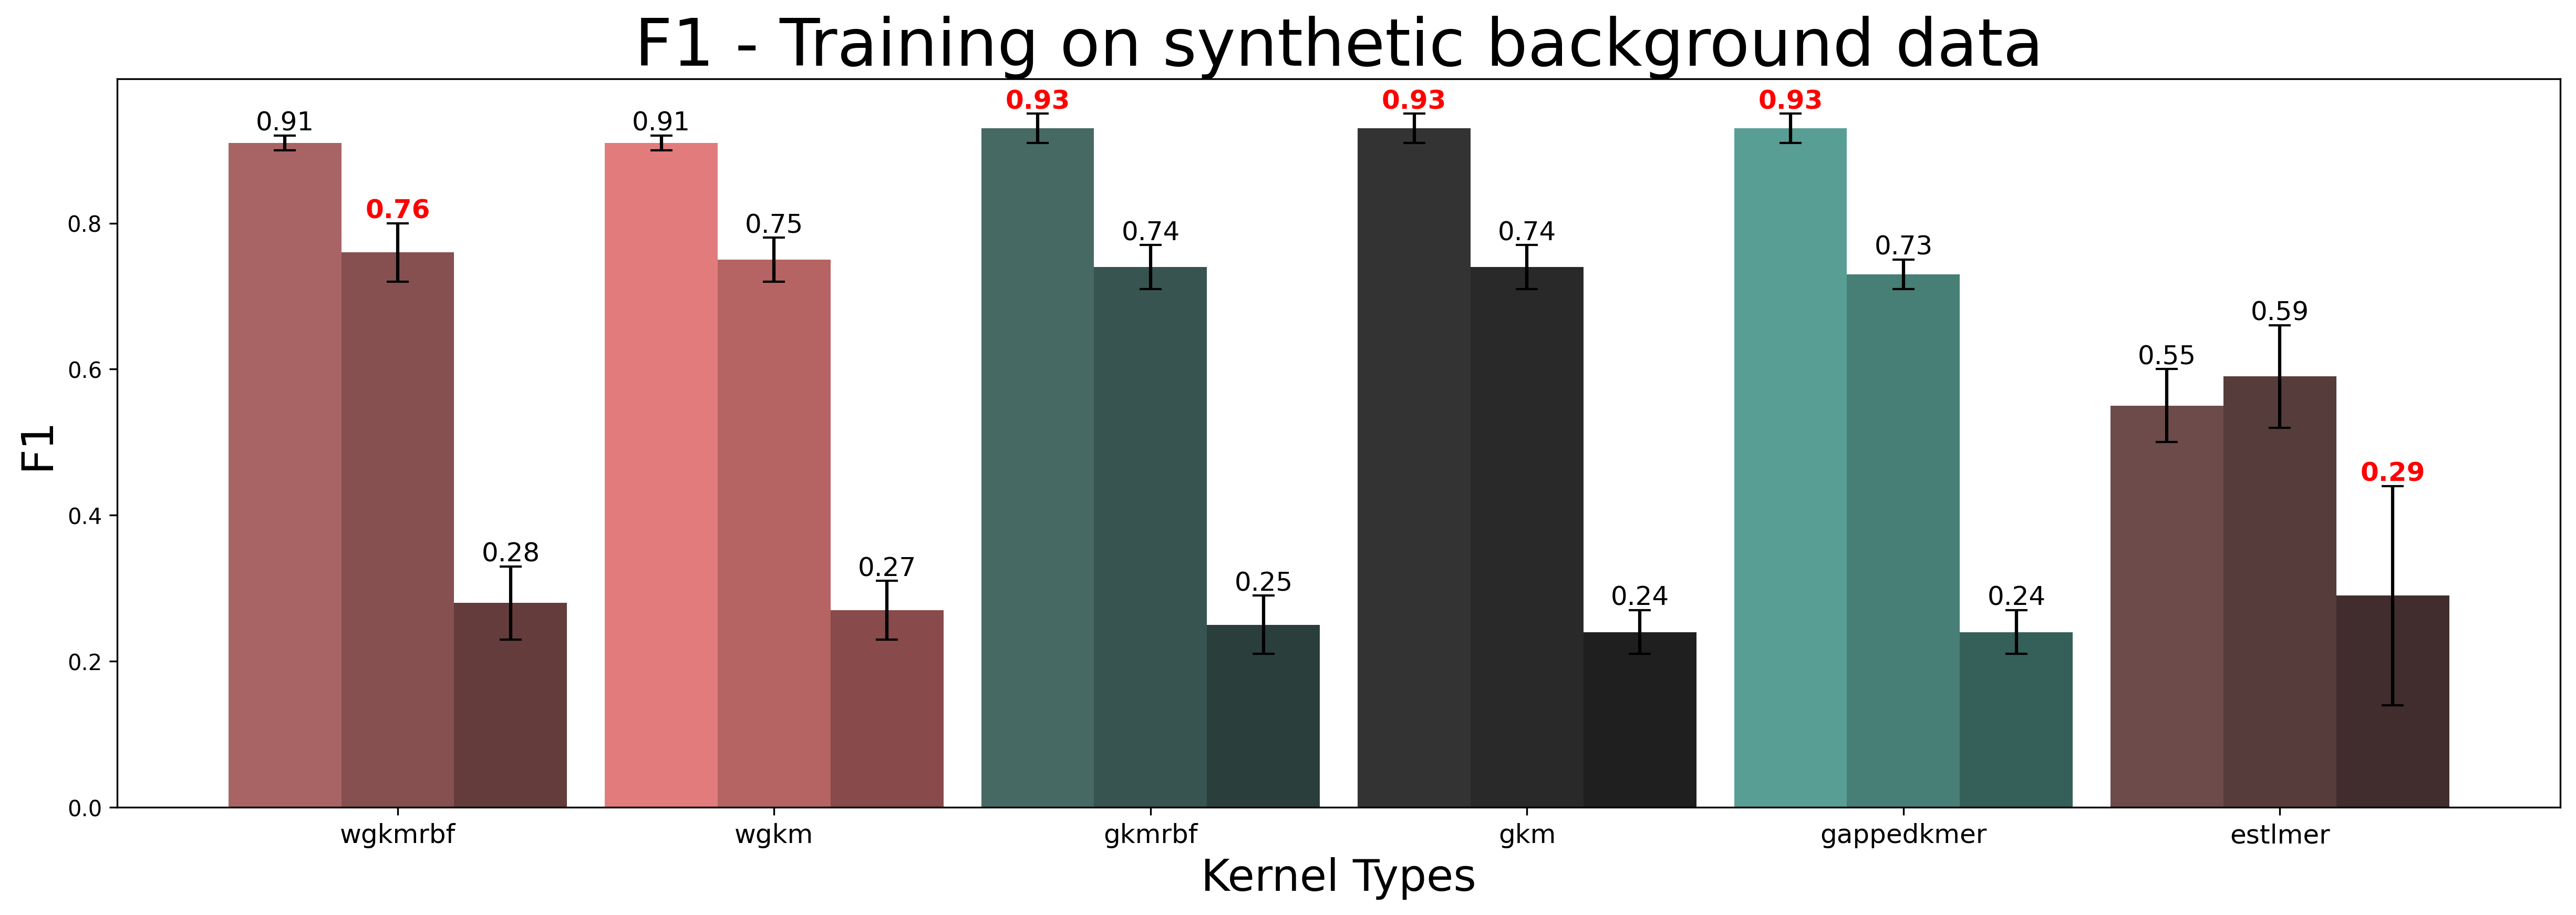

In [9]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in BGTRAIN:
    barplot(performance_dir, "F1", bg)
    